# ElementTracers - An In-Depth Guide

Hello, welcome to the tutorial for the Element "age" tracer module in FIRE. If you are interested in what the ElementTracers are designed for and what they do, read below. If you just want to see the dang code that makes them work, scroll on.

<b>Motivation</b>: currently, when running a simulation we have to pre-select stellar mass loss rates (how much mass does a star lose) and nucleosynthetic yields (how much of a given element does a star produce throughout its lifetime). The combination of these two can be colloquially referred to as 'feedback' from stars (though feedback also includes the energy of the explosion and how it dissapates into the surrounding interstellar medium).
Given that a Milky-way mass simulation can take many weeks/months to run from start to finish, testing variations of massloss rates and yields is prohibitively expensive. 

The element tracers take advantage of the fact that we use simulations to track the <b>number of feedback events</b> that occur for a given <b>star particle</b> as a function of its <b>age</b>. The manner in which we observe this is through the effect a feedback event has on <b>surrounding gas</b>, which records and accumulates the feedback byproducts from stars for some time before the gas itself turns into a star.

When this last step occurs, the star particle inherits the accumulated feedback events in two ways:

(1) the traditional method, where the ejecta are actually calculated and then distributed among surrounding gas

(2) the ElementTracer method, where the ejecta are not explicitly calculated, but the total 'weight' of events is preserved instead, within bins of age.

I will explain more about this later.

<b>Purpose</b>: We want to leverage these 'weights' to test variations of mass loss rates and nucleosynthetic yields in realtime.

<hr>

# How to run?

Import standard libraries:

In [1]:
from ipywidgets import interact, interactive, fixed, interact_manual
import numpy as np
import gizmo_analysis as gizmo
import utilities as ut
from matplotlib import pyplot as plt
import scipy
import copy

small change


At the time of writing (8/3/23), you will have to manually add the following two files on top of the standard installation of <a href = "https://bitbucket.org/awetzel/gizmo_analysis/src/master/">gizmo_analysis</a> from Andrew:

<b>gizmo_model.py</b> (can be found in my repo on github: https://github.com/patelpb96/GizmoElementTracers)

<b>gizmo_agetracer.py</b> (same as above, even though Andrew has added in his own version. Ideally, at some point, his will just include my class and we'll be good to go with his gizmo_analysis alone. If that is the case, then ignore this, but if it is not, refer to my repo.) Here's what my gizmo_analysis folder generally looks like (not every last file, but all the .py ones besides setup.py)

<img src ="https://i.imgur.com/nriNegs.png">

## 0.0 : Diagnostics, run this to be sure everything is atleast loading in and looks right

Of course, first just see if the libraries are importing. Once they're imported, run the following to test if gizmo_model is working as intended. It will just plot the mass loss rates and nucleosynthetic yields that I've already put into the code, without assuming any progenitor metallicity (Z = 1). 

### 0.1 : basic testing of gizmo_model

See if the code below runs.

In [2]:
elem = None #'None' - No specific element, otherwise specify one of 'metals', 'iron', etc.

winds = gizmo.gizmo_model.feedback(source = 'wind', elem_name = elem) # initializing a class for Stellar Winds
ccsn = gizmo.gizmo_model.feedback(source = 'cc', elem_name = elem) #initializing a class for CCSN
wdsn = gizmo.gizmo_model.feedback(source = 'wd', elem_name = elem) #initializing a class for Type Ia/WDSN 
solar_values = gizmo.gizmo_model.get_sun_massfraction() # abundances of elements in the sun
#EYD = gizmo.gizmo_model.EventYieldDictionary() #nucleosynthetic yields of each element tracked by FIRE

element_names = [element_name.lower() for element_name in solar_values]
print("Available Elements:\n", element_names)

Available Elements:
 ['metals', 'helium', 'carbon', 'nitrogen', 'oxygen', 'neon', 'magnesium', 'silicon', 'sulfur', 'calcium', 'iron']


We can plot the rates that have already been implemented:

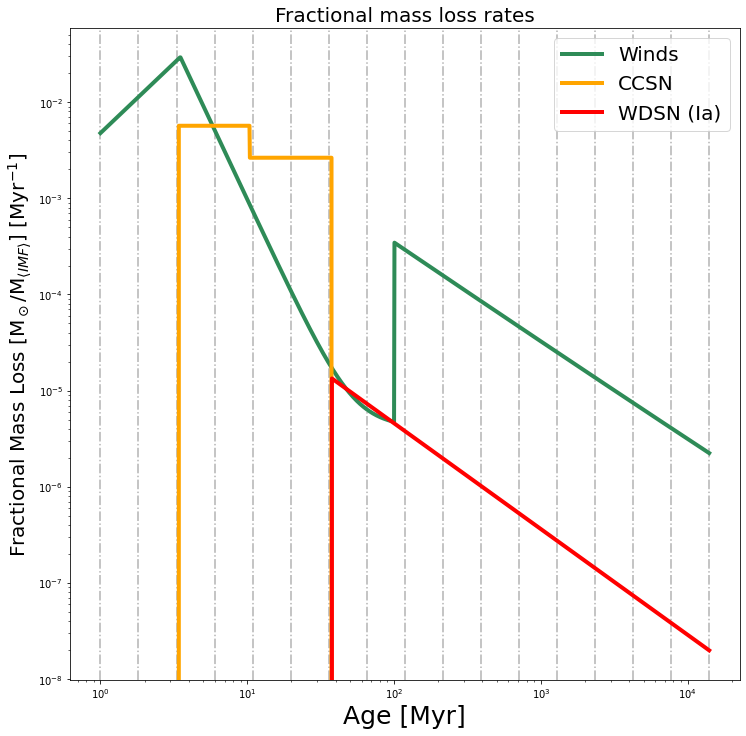

In [3]:
# rate_X = massloss rate, ages_X = total timespan, or 0 to 13.7 Gyr, d_X is the array of times at which there 
# are discontinuities in the ages. For more info, see the return values in:
# gizmo_model.py -> feedback -> get_rate_X

agebins = np.logspace(np.log10(1),np.log10(14000),17)
agebinning = True

rate_wind, ages_wind, d_wind = winds.get_rate_wind()
rate_ccsn, ages_ccsn, d_ccsn = ccsn.get_rate_cc()
rate_wdsn, ages_wdsn, d_wdsn = wdsn.get_rate_wd()

fig, (ax1) = plt.subplots(1,1, figsize = (12,12))

if agebinning == True:
    for i in agebins:
        ax1.axvline(i, ls = "-.", c = 'k', alpha = 0.3)
ax1.loglog()
ax1.plot(ages_wind, rate_wind, lw = 4, c = 'seagreen', label = "Winds")
ax1.plot(ages_ccsn, rate_ccsn, lw = 4, c = 'orange', label = "CCSN")
ax1.plot(ages_wdsn, rate_wdsn, lw = 4, c = 'r', label = "WDSN (Ia)")
ax1.legend(fontsize = 20)
ax1.set_title("Fractional mass loss rates", size = 20)
ax1.set_xlabel("Age [Myr]", size = 25)
ax1.set_ylabel(r"Fractional Mass Loss [M$_\odot$/M$_{\langle IMF \rangle}$] [Myr$^{-1}$]", size = 20)
plt.show()

Generally, this shows the relative amount of mass lost by a population of stars at a given age. Most precisely, for any given star particle, here is the fraction of mass that is lost relative to the IMF-averaged mass of all stars at that age.

"IMF" refers to the "initial mass function", which determines the distribution of masses of stars in a population. Nice overview: https://ned.ipac.caltech.edu/level5/March18/Hopkins/Hopkins2.html

But you will learn the IMF the best by trying to plot out and calculate values yourself. Problem 2.5 in "Galaxies in the Universe" by "Sparke and Gallagher" is a great review of the IMF and how to use it. 

Complimentary to the above plot, the one below should plot the <b>relative amount of each element produced</b> by each type of feedback event. 

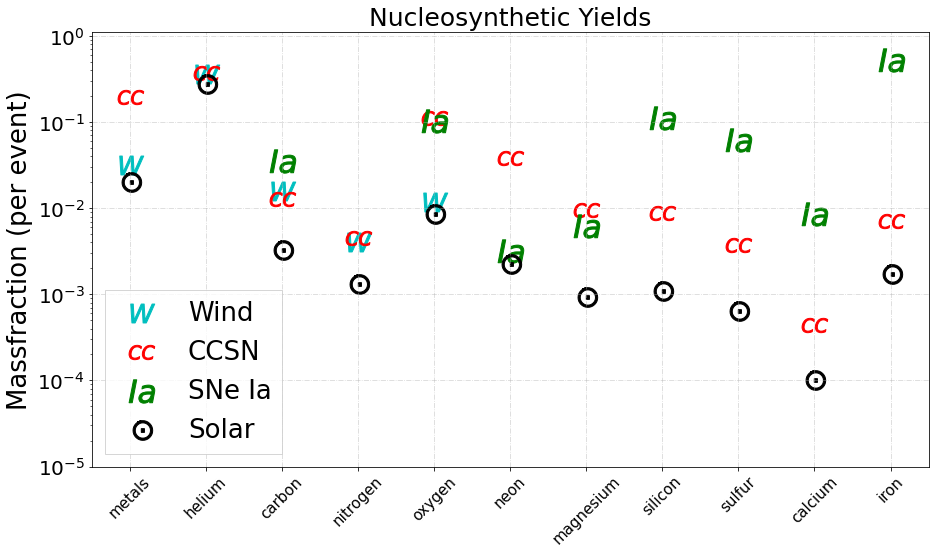

In [4]:
gizmo.gizmo_model.EventYieldDictionary.plot_yields()

### 0.2 : basic testing of gizmo_agetracer 

The class I developed to enable easy variations of the ElementTracers is called "FIREYieldClass2" at the time of writing.

In [5]:
FYC2 = gizmo.gizmo_agetracer.FIREYieldClass2()


All that is meant by these 'age bins' is that we can divide the timeline of a star particle into some number of intervals in logspace. The standard right now is 16 bins. Every star/gas particle has some empty array with 16 spots, i.e.

weights = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]

If a star particle forms and experiences a supernova event 40 Myr after it forms, then the 'weight' of that event is split into some geometric fraction surrounding the star particle. 

we can integrate over this weight with an assumed mass loss rate to reverse engineer the total ejecta contained within a star, and therefore, the relative abundance of elements within it. 

# 1.0 Loading in an Agetracer Sim and Varying the Rates 

In [6]:
# Dictionary with galaxy name and corresponding local directory containing the HDF5 - for ease of access. 

dirs = { 'm11b_hires' : 'D:\Data\m11b_res260' , 'm11q' : 'D:\Data\m11q_res880', 
       'm11h' : 'D:\Data\m11h_res880', 'm10v' : 'D:\Data\m10v_res250',
       'm11d' : 'D:\Data\m11d_res7100', 'm12i' : 'D:\Data\m12i_res7100',
       'm12i_low_res' : 'D:\Data\m12i_res57000', 'm11e' : 'D:\Data\m11e_res7100',
       'm11i' : 'D:\Data\m11i_res7100', 'm10q' : 'D:\Data\m10q_res250',
       'm09' : 'D:\Data\m09_res30', 'm11b_cr' : 'D:\Data\m11b_res2100_v2', 'm11b' : 'D:\Data\m11bfin',
       'm12i_age' : 'D:\Data\m12i_agetrace', 'm12i_maoz' : 'D:\Data\m12i_res57000_snia-maoz'}


# Function below loads the snapshot 600 from the directory that it has been assigned to. Simply use the galaxy's name
# in lowercase to get your data.

def load(galaxy):
    
    print('LOADING GALAXY: ' + galaxy + " in " + dirs[galaxy])
    
    part = gizmo.io.Read.read_snapshots(['star'], 'index', 600, assign_hosts = 'mass', assign_hosts_rotation=True,
                                        simulation_name=str(galaxy), simulation_directory=dirs[galaxy], particle_subsample_factor=5) #, assign_formation_coordinates = True
    
    species='star'

    return part

In [7]:
part = load('m12i_age')
#part2 = copy.deepcopy(part)

LOADING GALAXY: m12i_age in D:\Data\m12i_agetrace

# in utilities.simulation.Snapshot():
* reading:  D:\Data\m12i_agetrace/snapshot_times.txt

  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  D:\Data\m12i_agetrace/output\snapshot_600.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 8820344 particles
    dark2     (id = 2): 3081337 particles
    gas       (id = 0): 5942109 particles
    star      (id = 4): 3068136 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['star']

* reading particles from:
    D:\Data\m12i_agetrace/output\snapshot_600.hdf5

! cannot find MUSIC config file:  D:\Data\m12i_agetrace/*/*.conf
! missing cosmological parameters, assuming the following (from AGORA):
  assuming sigma_8 = 0.807
  assuming n_s = 0.961

* periodically subsampling all particles by factor = 5

* checking sanity of particle properties


# in utilities.particle.get_ce

## 1.1 Sanity Check

The below should run, you'll typically see 16 age bins from 1 Myr to 13700 Myr in logspace. Other basic diagnostic information available below.

In [8]:
print('number of age bins = {}'.format(part.info['agetracer.age.bin.number']))

# if age-tracer model used bins equally spaced in log age (which is the default), the min and max age of these bins [Myr] (though GizmoAnalysis will over-ride the age min to be 0)
if 'agetracer.age.min' in part.info:
    print('age min,max = {}, {} Myr'.format(part.info['agetracer.age.min'], part.info['agetracer.age.max']))

# alternately, if the simulation used custom age bins, this lists them
if 'agetracer.age.bins' in part.info:
    print('age bins = {}'.format(part.info['agetracer.age.bins']))

# targeted number of age-tracer injection events per age bin
# if <= 0, this means Gizmo deposited weights at each timestep
print('targeted number of events per age bins = {}'.format(part.info['agetracer.event.number.per.age.bin']))

#part['gas'].ElementAgeTracer = gizmo.agetracer.ElementAgeTracerClass(part.info)
part['star'].ElementAgeTracer = gizmo.agetracer.ElementAgeTracerClass(part.info)

print(part['star'].ElementAgeTracer.keys())
print(part['star'].ElementAgeTracer['age.bins'])
#print(gizmo.agetracer.ElementAgeTracerClass.assign_element_initial_massfraction(part['star']))
species_name = 'star'

sun_massfraction = gizmo.gizmo_model.get_sun_massfraction()
element_names = [element_name.lower() for element_name in sun_massfraction]

number of age bins = 16
age min,max = 1.0, 13700.0 Myr
targeted number of events per age bins = 10.0
dict_keys(['has.custom.age.bin', 'event.number.per.age.bin', 'age.bin.number', 'age.bins', 'element.index.start', 'yield.massfractions', 'initial.massfraction'])
[0.00000000e+00 1.81361473e+00 3.28919840e+00 5.96533869e+00
 1.08188261e+01 1.96211825e+01 3.55852657e+01 6.45379622e+01
 1.17046999e+02 2.12278162e+02 3.84990803e+02 6.98224992e+02
 1.26631113e+03 2.29660053e+03 4.16514856e+03 7.55397480e+03
 1.37000000e+04]


## 1.2 Generate Yield Dictionaries

This is where you generate Yield Dictionaries based on the feedback model you want to implement. 

    fya_def = gizmo.agetracer.FIREYieldClass2('fire2.1')
    fya_2 = gizmo.agetracer.FIREYieldClass2('fire2.1', tdd_ia = -0.9)
    
The first is the agetracer class with default FIRE-2 values (+ Maoz)
The second is a slightly altered delay-time-distribution-exponent. Since the rate of WDSN $\text{rate} \propto t^{\sim 1.1}$, we try $\text{tdd_ia} = -0.9$ to see the effects. So fya_def will be the control, and fya_2 will guide the alteration.

In [9]:
fya_def = gizmo.agetracer.FIREYieldClass2('fire2.1')
eyd_def = fya_def.get_element_yields(part['star'].ElementAgeTracer['age.bins'], continuous = True)

fya_2 = gizmo.agetracer.FIREYieldClass2('fire2.1', ia_type = "maoz", tdd_ia = -0.9)
eyd_2 = fya_2.get_element_yields(part['star'].ElementAgeTracer['age.bins'], continuous = True)

for elem in ['metals', 'iron', 'oxygen']:
    print("Ratio of Element Yield Dictionaries - " + str(elem) + "\n" + str(eyd_def[elem]/eyd_2[elem]))
    print("")

Ratio of Element Yield Dictionaries - metals
[1.         1.         1.         1.         1.         1.
 1.24062182 1.4594311  1.19755549 1.13125887 1.0674143  1.00617727
 0.94768187 0.89204087 0.83934654 0.78967248]

Ratio of Element Yield Dictionaries - iron
[       nan        nan 1.         1.         1.         1.
 1.56299384 1.62998064 1.44701635 1.28458969 1.14039532 1.01238667
 0.89874691 0.79786314 0.70830352 0.6287969 ]

Ratio of Element Yield Dictionaries - oxygen
[1.         1.         1.         1.         1.         1.
 1.02090604 1.1299219  1.03172021 1.02170483 1.01148477 1.00108443
 0.99053519 0.9798764  0.96915651 0.9584344 ]



<ipython-input-9-6e94f0ff9362>:8: RuntimeWarning: invalid value encountered in true_divide
  print("Ratio of Element Yield Dictionaries - " + str(elem) + "\n" + str(eyd_def[elem]/eyd_2[elem]))


You should see in the print statement at the end that varying the time delay (tdd_ia) yields a dictionary with differing amounts of metals from the default values. This is not the case in the first 4 or 5 bins, because WDSN have not started yet, so we would not expect any variation.

In [10]:
part[species_name].ElementAgeTracer.assign_element_yield_massfractions(eyd_def)

at_FeH = part[species_name].prop('metallicity.agetracer.fe')
at_MgFe = part[species_name].prop('metallicity.agetracer.mg - metallicity.agetracer.fe')

############################################################################################
part[species_name].ElementAgeTracer.assign_element_yield_massfractions(eyd_2, flush = True)

at_FeH2 = part[species_name].prop('metallicity.agetracer.fe')
at_MgFe2 = part[species_name].prop('metallicity.agetracer.mg - metallicity.agetracer.fe')

C:\Users\patel\OneDrive\Desktop\research2\gizmo_analysis\gizmo_io.py:298: RuntimeWarning: invalid value encountered in subtract
  prop_values = prop_values - self.prop(prop_name, indices)


NOTE: After you generate the first element yield dictionary and corresponding abundances, you can't overwrite it with a new one to generate new elemental abundances. To keep the code smooth, I added a 'flush' parameter, which allows you to overwrite the previously-written dictionary. 

## 1.3 Plot Results in Elemental Abundance Space: [Mg/Fe] vs [Fe/H]

Now I can plot the results of making a variation to the time-delay-distribution of Ia's and see what effect it may have on the final yields at present day.

In [11]:
def plot_vals(X1,Y1,X2,Y2, include_winds = True, include_cc = True, include_wd = True, include_wd2 = True,
             tdd = -0.9,
             axes1lim = [[-3,1],[-0.25,0.375]]):
    i = None
    str_title = 'Total'

    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,8))

    _wind = gizmo.gizmo_model.feedback(source = 'wind', elem_name = i)
    _wd = gizmo.gizmo_model.feedback(source = 'ia', elem_name = i, ia_model = 'maoz')
    _wd2 = gizmo.gizmo_model.feedback(source = 'ia', elem_name = i, t_dd = tdd, ia_model = 'maoz')
    _ccsn = gizmo.gizmo_model.feedback(source = 'cc', elem_name = i)

    r_wind, a_wind, t_wind = _wind.get_rate_wind()
    r_wd, a_wd, t_wd = _wd.get_rate_wd()
    r_wd2, a_wd2, t_wd2 = _wd2.get_rate_wd()
    r_cc, a_cc, t_cc = _ccsn.get_rate_cc()

    wd_int = scipy.integrate.cumtrapz(r_wd, a_wd)
    wd_int2 = scipy.integrate.cumtrapz(r_wd2, a_wd2)
    cc_int = scipy.integrate.cumtrapz(r_cc, a_cc)
    
    
    # Normalizing the WDSN/SNe Ia rates. Same with CC
    N_fid = (wd_int[-1])
    _N_var = (wd_int2[-1])
    N_fid_cc = (cc_int[-1])
    A = N_fid / _N_var
    N_var = A*_N_var

    subsample = 10
    ax1.scatter(X1[::subsample], Y1[::subsample], s = 0.3, c = 'r')

    ax1.scatter(X2[::subsample], Y2[::subsample], s = 0.3, c = 'k')

    ax1.set_xlabel("[Fe/H]", size = 20)
    ax1.set_ylabel("[Mg/Fe]", size = 20)
    ax1.set_xlim(axes1lim[0][0],axes1lim[0][1])
    ax1.set_ylim(axes1lim[1][0],axes1lim[1][1])

    ax2.loglog()
    
    if include_winds:
        ax2.plot(a_wind, r_wind, lw = 4, c = 'seagreen', label = "Winds")
    if include_cc:
        ax2.plot(a_cc, r_cc, lw = 4, c = 'orange', label = "CCSN")
    if include_wd:
        ax2.plot(a_wd, r_wd, lw = 4, c = 'r', label = "WDSN (Ia)")
        ax1.scatter(-6,0,s = 35, c = 'r', label = r"WDSN")
    if include_wd2:
        ax2.plot(a_wd2, A*r_wd2, lw = 4, c = 'k', ls = "-.", label = r"WDSN$_2$ (Ia)")
        ax1.scatter(-6,0,s = 35, c = 'k', label = r"WDSN$_2$")

    ax1.legend(fontsize = 20, loc = 3)
    ax2.legend(fontsize = 20, loc = 1)
    ax2.set_title("Fractional mass loss rates: " + str_title, size = 20)
    ax2.set_xlabel("Age [Myr]", size = 25)
    ax2.set_ylabel(r"Fractional Mass Loss [M$_\odot$/M$_{\langle IMF \rangle}$] [Myr$^{-1}$]", size = 20)
    plt.show()

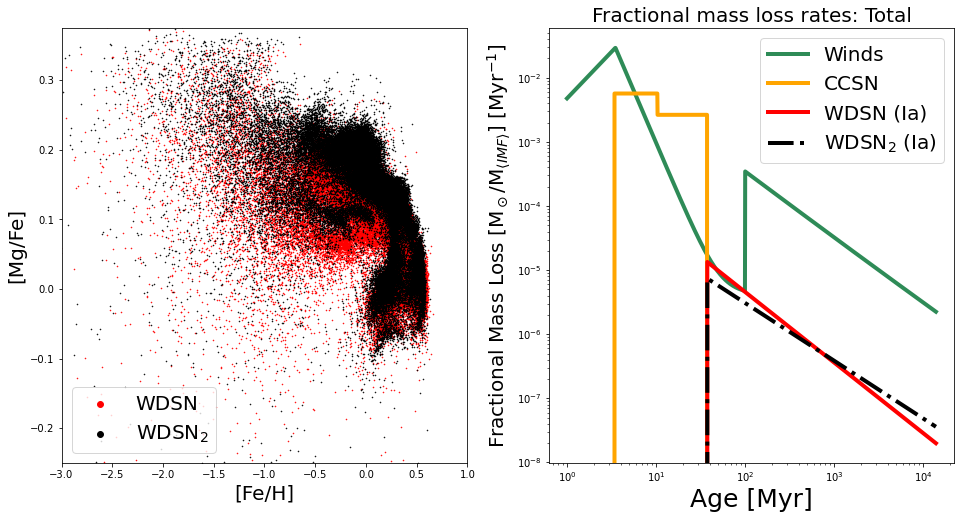

In [12]:
plot_vals(at_FeH, at_MgFe, at_FeH2, at_MgFe2)

In [13]:
#fya_def = gizmo.agetracer.FIREYieldClass2('fire2.1')
#eyd_def = fya_def.get_element_yields(part['star'].ElementAgeTracer['age.bins'], continuous = True)
#
#fya_3 = gizmo.agetracer.FIREYieldClass2('fire2.1', ia_type = "maoz", tdd_ia = -1.4)
#eyd_3 = fya_3.get_element_yields(part2['star'].ElementAgeTracer['age.bins'], continuous = True)
#############################################################################################
#part[species_name].ElementAgeTracer.assign_element_yield_massfractions(eyd_def, flush = True)
#
#at_FeH = part[species_name].prop('metallicity.agetracer.fe')
#at_MgFe = part[species_name].prop('metallicity.agetracer.mg - metallicity.agetracer.fe')
#############################################################################################
#part[species_name].ElementAgeTracer.assign_element_yield_massfractions(eyd_3, flush = True)
#
#at_FeH3 = part[species_name].prop('metallicity.agetracer.fe')
#at_MgFe3 = part[species_name].prop('metallicity.agetracer.mg - metallicity.agetracer.fe')

In [14]:
#plot_vals(at_FeH, at_MgFe, at_FeH3, at_MgFe3, tdd = -1.4)
#plot_vals(at_FeH, at_MgFe, at_FeH3, at_MgFe3, include_wd = False, include_winds = False, include_wd2 = False, axes1lim = [[-4,1],[-0.25,0.375]])

In [15]:
@interact(_tdd = [-1.5,-1.3,-1.1,-0.9,-0.7,-0.5])
def ia_variation_plot(_tdd = -1.1):
    fya_def = gizmo.agetracer.FIREYieldClass2('fire2.1')
    eyd_def = fya_def.get_element_yields(part['star'].ElementAgeTracer['age.bins'], continuous = True)

    fya_3 = gizmo.agetracer.FIREYieldClass2('fire2.1', ia_type = "maoz", tdd_ia = _tdd)
    eyd_3 = fya_3.get_element_yields(part['star'].ElementAgeTracer['age.bins'], continuous = True)
    ############################################################################################
    part[species_name].ElementAgeTracer.assign_element_yield_massfractions(eyd_def, flush = True)

    at_FeH = part[species_name].prop('metallicity.agetracer.fe')
    at_MgFe = part[species_name].prop('metallicity.agetracer.mg - metallicity.agetracer.fe')
    ############################################################################################
    part[species_name].ElementAgeTracer.assign_element_yield_massfractions(eyd_3, flush = True)

    at_FeH3 = part[species_name].prop('metallicity.agetracer.fe')
    at_MgFe3 = part[species_name].prop('metallicity.agetracer.mg - metallicity.agetracer.fe')
    
    plot_vals(at_FeH, at_MgFe, at_FeH3, at_MgFe3, tdd = _tdd)

interactive(children=(Dropdown(description='_tdd', index=2, options=(-1.5, -1.3, -1.1, -0.9, -0.7, -0.5), valu…

## 2.0 Isolating Feedback Channels 

Say we want to evaluate JUST the contribution from winds, or JUST the contribution from CCSN/WDSN. How can we do that?

Well, we can assign yields based on just one of those channels with the <font face="courier new">testing</font> parameter:

    FIREYield.get_element_yields(part_cc['star'].ElementAgeTracer['age.bins'], testing = 'cc')
    FIREYield.get_element_yields(part_cc['star'].ElementAgeTracer['age.bins'], testing = 'ia')
    FIREYield.get_element_yields(part_cc['star'].ElementAgeTracer['age.bins'], testing = 'winds')
    
    
## 2.1 Massfractions Using Isolated Feedback Channels

Say we load two element yield dictionaries, one that solely integrates over the CCSN and another which solely integrates over WDSN rates. We can use the above to initialize the element yield dictionary and then generation massfractions in metals for stars. Each star will have a final metal value that corresponds to a 'set' of feedback rates which only includes one feedback channel. This allows us to assess what the relative contribution of CCSN is versus that of WDSN (for example). 

In [16]:
FIREYield = gizmo.agetracer.FIREYieldClass2('fire2.1', ia_type='maoz') 
eabins = part['star'].ElementAgeTracer['age.bins']

Element_Yield_Dictionary_CCSN = FIREYield.get_element_yields(eabins, testing = 'cc', continuous = True)
Element_Yield_Dictionary_WDSN = FIREYield.get_element_yields(eabins, testing = 'ia', continuous = True)

part['star'].ElementAgeTracer.assign_element_yield_massfractions(Element_Yield_Dictionary_CCSN, flush = True)
cc_metal_massfraction = part['star'].prop('massfraction.agetracer.metals')

part['star'].ElementAgeTracer.assign_element_yield_massfractions(Element_Yield_Dictionary_WDSN, flush = True)
wd_metal_massfraction = part['star'].prop('massfraction.agetracer.metals')

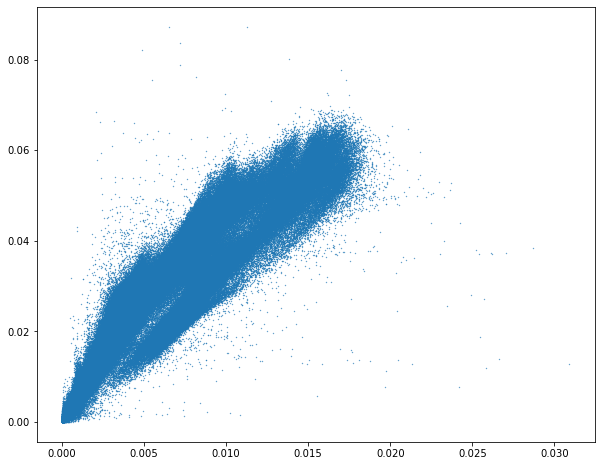

In [17]:
plt.figure(figsize = (10,8))
plt.scatter(wd_metal_massfraction,cc_metal_massfraction, s = 0.1)
plt.show()